In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

sys.path.append(os.path.abspath('..'))

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
from hit_finding.constants import *
from hit_finding.metrics import *

# Compare Hits Reproduction

In [5]:
zscores = extract_scores_from_all(extract_score, threshold=4)
joined = pd.concat(zscores.values())
joined.shape

...................................

(11197, 18)

In [6]:
joined.columns

Index(['AGP_map', 'DNA_map', 'ER_map', 'Mito_map', 'RNA_map', 'ALL_map',
       'AGP_raw', 'DNA_raw', 'ER_raw', 'Mito_raw', 'RNA_raw', 'ALL_raw',
       'AGP_raw1to1', 'DNA_raw1to1', 'ER_raw1to1', 'Mito_raw1to1',
       'RNA_raw1to1', 'ALL_raw1to1'],
      dtype='object')

In [7]:
joined.filter(regex='_map').columns

Index(['AGP_map', 'DNA_map', 'ER_map', 'Mito_map', 'RNA_map', 'ALL_map'], dtype='object')

In [45]:
from reproducibility.ReproducibilityContext import ReproducibilityContext
from reproducibility.ReproducibilityStrategy import *
from reproducibility.FilterStrategy import *

In [19]:
from tqdm.notebook import tqdm

In [21]:
import joblib

In [39]:
rep_cont = ReproducibilityContext(None, None)
res = dict()
for method in ['map', 'raw']:
    res[method] = dict()
    cur = joined.filter(regex=f'_{method}')

    res[method]['abs'] = dict()
    for rep_name in ['mean', 'chan_vector']:
            res[method]['abs'][rep_name] = []
            
    for abs_filter in tqdm(np.arange(0.05, 0.81, 0.05)):
        filter_strg = AbsoluteFilterStrategy(abs_filter)
        for rep_name, rep_strg in zip(['mean', 'chan_vector'], [MeanDistanceStrategy(), VectorDistanceStrategy()]):
            rep_cont.filter_strategy = filter_strg
            rep_cont.reproducibility_strategy = rep_strg
            cur_res = rep_cont.compare_triplets(cur, f'ALL_{method}')
            metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()
            del cur_res
            res[method]['abs'][rep_name].append((abs_filter, metric))
            joblib.dump(res, '/home/naorko/res_dict.sav')
            
    res[method]['topk'] = dict()
    for rep_name in ['mean', 'chan_vector']:
        res[method]['topk'][rep_name] = []
        
    for topk_filter in tqdm(range(50, 1001, 50)):
        filter_strg = TopKFilterStrategy(topk_filter)
        for rep_name, rep_strg in zip(['mean', 'chan_vector'], [MeanDistanceStrategy(), VectorDistanceStrategy()]):
            rep_cont.filter_strategy = filter_strg
            rep_cont.reproducibility_strategy = rep_strg
            cur_res = rep_cont.compare_triplets(cur, f'ALL_{method}')
            metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()
            del cur_res
            res[method]['topk'][rep_name].append((topk_filter, metric))
            joblib.dump(res, '/home/naorko/res_dict.sav')

  0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipykernel_627/3136278443.py:17: RuntimeWarning: invalid value encountered in double_scalars
  metric = cur_res['Metric'].sum().sum() / cur_res['Triplet Count'].sum().sum()


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [25]:
print(res.keys())
print(res['map'].keys())
print(res['map']['abs'].keys())

dict_keys(['map', 'raw'])
dict_keys(['abs', 'topk'])
dict_keys(['mean', 'chan_vector'])


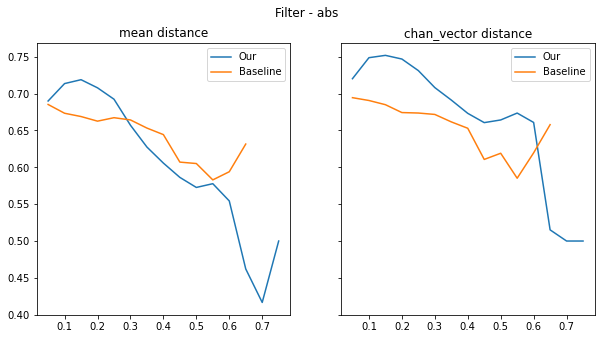

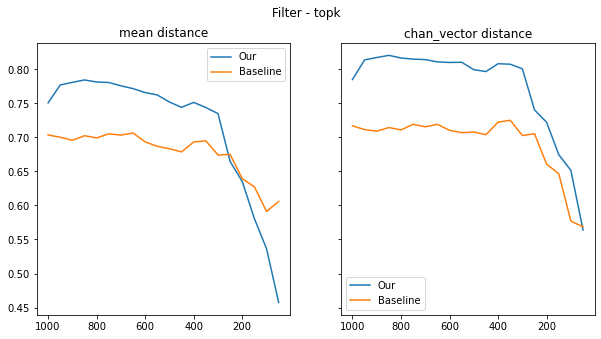

In [40]:
for filter_type in ['abs', 'topk']:
    fig, ax = plt.subplots(ncols=2, figsize=(2*5,5), sharey=True)
    fig.suptitle(f'Filter - {filter_type}')
    
    for i, metric in enumerate(['mean', 'chan_vector']):
        ax[i].set_title(f'{metric} distance')
        
        for method in ['map', 'raw']:
            x, y = zip(*res[method][filter_type][metric])
            ax[i].plot(x, y)
    
        if filter_type == 'topk':
            ax[i].invert_xaxis()
        ax[i].legend(['Our', 'Baseline'])

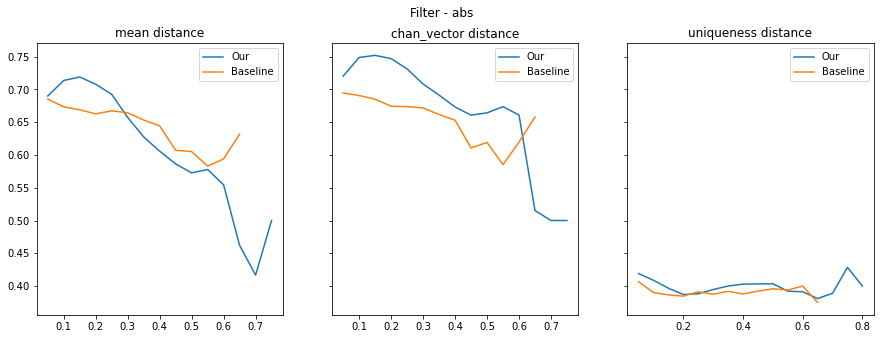

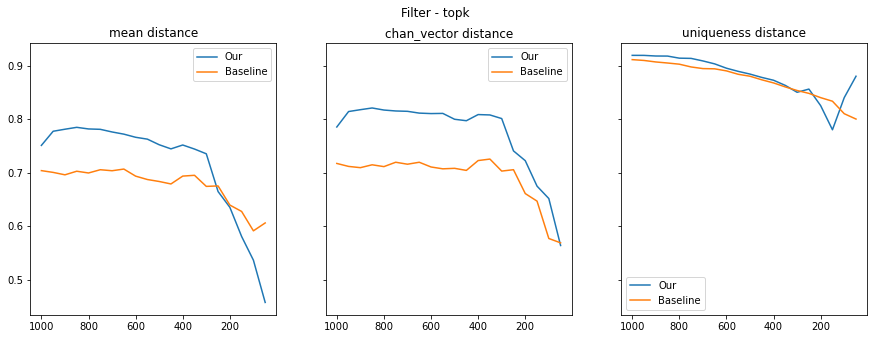

In [47]:
for filter_type in ['abs', 'topk']:
    fig, ax = plt.subplots(ncols=3, figsize=(3*5,5), sharey=True)
    fig.suptitle(f'Filter - {filter_type}')
    
    for i, metric in enumerate(['mean', 'chan_vector', 'uniqueness']):
        ax[i].set_title(f'{metric} distance')
        
        for method in ['map', 'raw']:
            x, y = zip(*res[method][filter_type][metric])
            ax[i].plot(x, y)
    
        if filter_type == 'topk':
            ax[i].invert_xaxis()
        ax[i].legend(['Our', 'Baseline'])

In [34]:
x

(50, 100, 150, 200, 250, 300)

In [46]:
rep_cont = ReproducibilityContext(None, None)
for method in ['map', 'raw']:
    cur = joined.filter(regex=f'_{method}')
            
    res[method]['abs']['uniqueness'] = []      
    for abs_filter in tqdm(np.arange(0.05, 0.81, 0.05)):
        filter_strg = AbsoluteFilterStrategy(abs_filter)
        for rep_name, rep_strg in zip(['uniqueness'], [UniquenessStrategy()]):
            rep_cont.filter_strategy = filter_strg
            rep_cont.reproducibility_strategy = rep_strg
            metric = rep_cont.dataframe_measure(cur, f'ALL_{method}')
            res[method]['abs'][rep_name].append((abs_filter, metric))
            joblib.dump(res, '/home/naorko/res_dict.sav')
            
    res[method]['topk']['uniqueness'] = []
    for topk_filter in tqdm(range(50, 1001, 50)):
        filter_strg = TopKFilterStrategy(topk_filter)
        for rep_name, rep_strg in zip(['uniqueness'], [UniquenessStrategy()]):
            rep_cont.filter_strategy = filter_strg
            rep_cont.reproducibility_strategy = rep_strg
            metric = rep_cont.dataframe_measure(cur, f'ALL_{method}')
            res[method]['topk'][rep_name].append((topk_filter, metric))
            joblib.dump(res, '/home/naorko/res_dict.sav')

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]